
# RNN Example for Time Series

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

--------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns=['Sales']

In [6]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


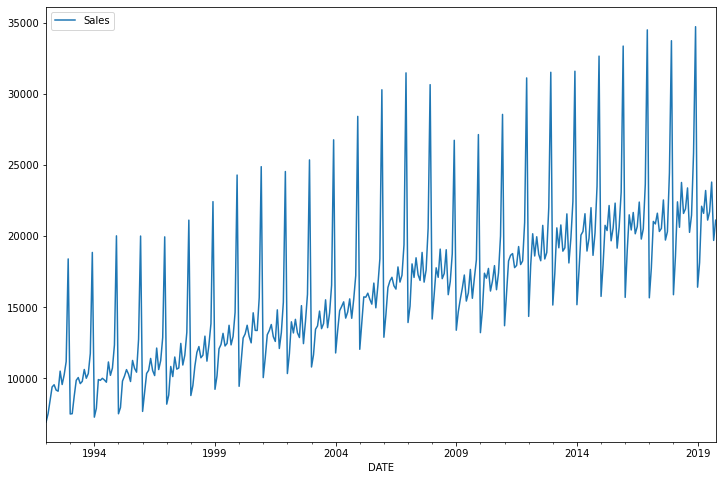

In [7]:
df.plot(figsize=(12,8));

------

# Train, Test Split
+ we need to cover data at least a year worth so that it can pick up seasonality if have any
+ Data is in `Monthly`
+ We gonna use 18 months (one and half year) for training

In [8]:
len(df)

334

In [9]:
test_size = 18

test_index_starting_point = len(df) - test_size

In [10]:
train = df.iloc[:test_index_starting_point]
test = df.iloc[test_index_starting_point: ]

In [11]:
train.shape, test.shape

((316, 1), (18, 1))

--------

# Scale Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

-------

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
len(test)

18

In [17]:
length = 12
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                               length=length, batch_size=batch_size)

In [18]:
# What does the first batch look like?
X, y = generator[0]

In [19]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


---------

# Model Building

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [21]:
n_features = 1

In [22]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# EarlyStopping and creating a Validation Generator

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [26]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                                                      length=length, batch_size=batch_size)

# Fit the model

In [27]:
model.fit(generator,
             validation_data = validation_generator,
             epochs=20,
             callbacks=[early_stopping],
             verbose=1)

Epoch 1/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0263 - val_loss: 0.0061
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0174 - val_loss: 0.0016
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0097 - val_loss: 6.8284e-04
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0030 - val_loss: 8.0435e-04
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 5.4507e-04
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0026 - val_loss: 4.8366e-04
Epoch 10/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0012 - 

In [28]:
losses = pd.DataFrame(model.history.history)

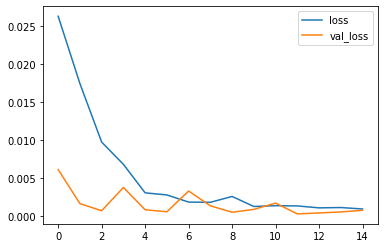

In [29]:
losses.plot();

--------

# Evaluate on Test Data

In [30]:
test_predictions = []

first_evaluation_batch = scaled_train[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # get prediction 1 time stamp ahead 
    # [0] is for grabbing just the number instead of [array]
    current_prediction = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_prediction)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

# Inverse Transformations and Compare

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

<ipython-input-32-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,23764,20839.729470
2018-06-01,21589,19800.764187
2018-07-01,21919,19923.547411
2018-08-01,23381,21509.263166
2018-09-01,20260,19219.778295


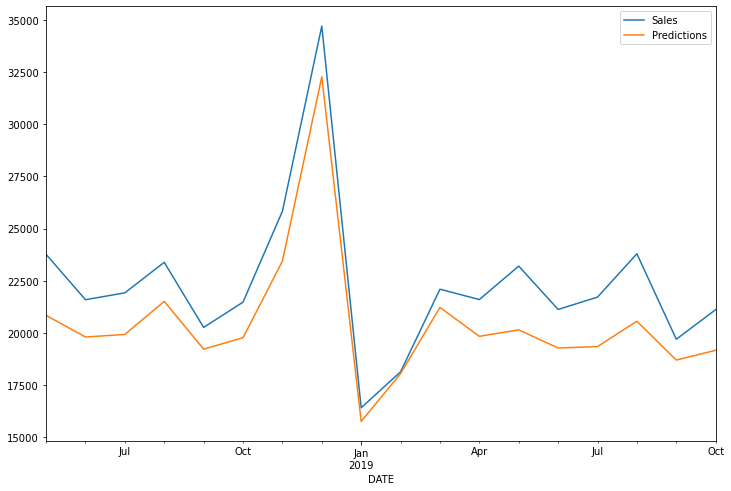

In [34]:
test.plot(figsize=(12,8));

If we decide the above predictions values are good enough, we will proceed to forecast for unknown future.

-----
--------

# Retrain on Whole dataset, and Forecasting

In [35]:
# Scaling
full_scaler = MinMaxScaler()

In [36]:
scaled_full_data = full_scaler.fit_transform(df)

In [37]:
# Generator 
length = 12
batch_size = 1

generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                                   length=length, batch_size=batch_size)

In [38]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

### We don't really need to use Early Stopping for forecasting because we are trying to forecast the unknown data.
+ How early stopping works in it monitor the validation loss like we have done during evaluation against validation data.
+ But for forecasting case, we basically try to predict the unknown future and want to fair without knowing the validation data.
+ That's why it is important to use early stopping step during evaluation in previous step (testing phase) before we finalize that we are satisfied with the results and try to forecast the future data in this step.

### For `number of epochs`, we might want to refer to the results of testing phase to see around where the loss is the lowest.
+ In this case, we will use 8.

In [42]:
model.fit(generator,
                epochs=8,
                verbose=1)

Epoch 1/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 8.0985e-04
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0010
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 9.0705e-04
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 9.5069e-04
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 8.7944e-04


In [45]:
forecast = []

periods = 12

first_evaluation_batch = scaled_full_data[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(periods):
    current_prediction = model.predict(current_batch)[0]
    
    forecast.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)
    

## Inverse Transform

In [46]:
forecast = full_scaler.inverse_transform(forecast)

# Creating new timestamp index with pandas.

In [51]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [49]:
forecast[:2]

array([[25134.83938169],
       [32721.84081936]])

### Pandas Frequency String
https://stackoverflow.com/questions/35339139/where-is-the-documentation-on-pandas-freq-tags

https://pandas.pydata.org/docs/user_guide/timeseries.html
+ `MonthBegin` **'MS'** - calendar month begin

**Alias**    **Description**
+ **B**       business day frequency
+ **C**          custom business day frequency
+ **D**          calendar day frequency
+ **W**          weekly frequency
+ **M**          month end frequency
+ **SM**         semi-month end frequency (15th and end of month)
+ **BM**         business month end frequency
+ **CBM**        custom business month end frequency
+ **MS**         month start frequency
+ **SMS**        semi-month start frequency (1st and 15th)
+ **BMS**        business month start frequency
+ **CBMS**       custom business month start frequency
+ **Q**          quarter end frequency
+ **BQ**         business quarter end frequency
+ **QS**         quarter start frequency
+ **BQS**        business quarter start frequency
+ **A, Y**       year end frequency
+ **BA, BY**     business year end frequency
+ **AS, YS**     year start frequency
+ **BAS, BYS**   business year start frequency
+ **BH**         business hour frequency
+ **H**          hourly frequency
+ **T, min**     minutely frequency
+ **S**          secondly frequency
+ **L, ms**     milliseconds
+ **U, u**  s    microseconds
+ **N**          nanoseconds

In [52]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq = 'MS') # we will start with the date where data on full data set ends

In [53]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [54]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

forecast_df.head()

,Forecast
2019-11-01,25134.839382
2019-12-01,32721.840819
2020-01-01,17087.332356
2020-02-01,18769.722623
2020-03-01,21797.252171


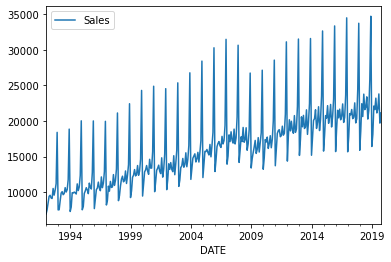

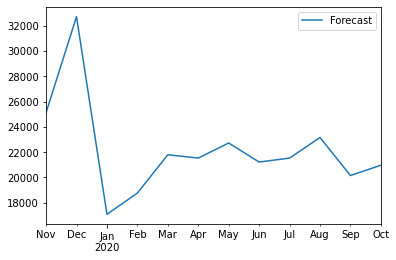

In [56]:
df.plot();
forecast_df.plot();

------

# Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

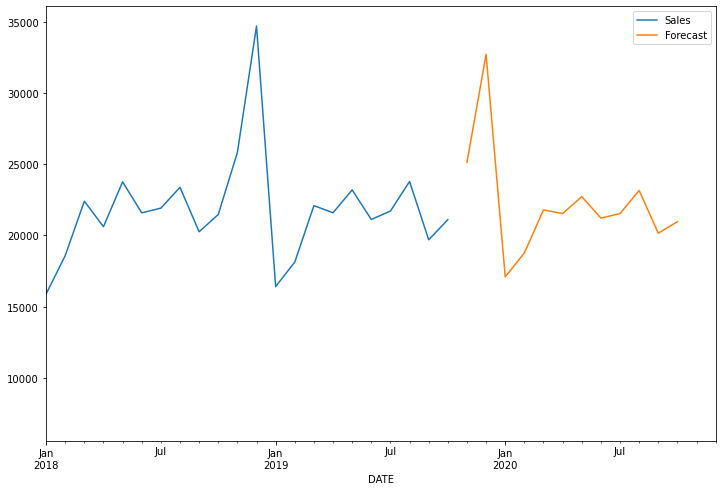

In [60]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8)); # plot on the same axis
plt.xlim('2018-01-1', '2020-12-01'); # zoom in the specific dates